# The Word2Vec Model
Welcome! Through the following lines of code, I have attempted to demonstrate the Word2Vec NN model using pytorch. You would actually need a much larger training corpus (>=10,000 words), than the one used in this code, in order to obtain a reasonably accurate set of word embeddings. You would also require a different type of softmax layer (hierarchical softmax) for faster computation. 

If you wish to modify certain parameters I would recommend following the guidelines given before each code cell.



In [1]:
# Importing required modules
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

### The Training Corpus


*   Defines the list containing the sentences that the model is to be trained on.
*   You can add/ edit/ delete sentences as per your preference, however DO NOT use punctuation or capitalization _(in order to avoid repetition of words)_.





In [2]:
 corpus = ['he is a king','she is a queen',
    'he is a man','i would like some mango juice',
    'she is a woman','i would like some orange juice','i would like some apple juice','nairobi is the capital of kenya',
    'delhi is the capital of india','oslo is the capital of norway'   
]

### Vocabulary and Word Indexing


*   Splits corpus sentences into individual word sequences
*   Generates a vocabulary of all words that occur in the training corpus
*   Assigns indices to words
*   Converts sequences of words into their respective index sequences




In [3]:
#returns list of sentences and distinct word vocabulary
def split_words(corpus):
  tokens = []
  vocab=set()
  for x in corpus:
    sep=x.split(' ')
    tokens.append(sep)
    vocab=vocab|set(sep)
  vocab=list(vocab)
  return tokens,vocab
sequences,vocab = split_words(corpus)
#maps word to index and index to word
word_to_ind={}
ind_to_word={}
ind=0
for word in vocab:
  word_to_ind[word]=ind
  ind_to_word[ind]=word
  ind+=1
#indexed sequences
seq_inds=[[word_to_ind[word] for word in sequence] for sequence in sequences]

### Window Selection and Context-Target Generation
*  The window size and mode for context words' range can be chosen:-
   *   Window mode bi-directional ('bi_dir') looks at words before and after the target word in sequence 2 times that of window size. 
   *   Window mode uni-directional ('uni_dir') looks at words only before the target word in sequence.
*  The loop iterates over the entire corpus and applies the pair_words function on all sequences.



In [4]:
window_size=2
mode='bi_dir'  


def pair_words_single(seq_ind,window):
  pairs=[]
  for target_pos in range(len(seq_ind)):
    context_start=max(target_pos-window,0)
    context_end=target_pos
    for context_pos in range(context_start,context_end):
      pairs.append((seq_ind[context_pos],seq_ind[target_pos]))
  return pairs
def pair_words_dual(seq_ind,window):
  pairs=[]
  for target_pos in range(len(seq_ind)):
    context_start=max(target_pos-window,0)
    context_end=min(target_pos+window+1,len(seq_ind))
    for context_pos in range(context_start,context_end):
      if context_pos!=target_pos:
        pairs.append((seq_ind[context_pos],seq_ind[target_pos]))
  return pairs
def pair_words(seq_ind,window_size=2,mode='bi_dir'):       #returns context-target pairs for a sequence of words/indices, given a window size(default=2) and mode(default=bi_dir)
  if mode=='uni_dir':
    return pair_words_single(seq_ind,window_size)
  else:
    return pair_words_dual(seq_ind,window_size)

all_pairs=[]
for seq_ind in seq_inds:                #loop iterates over all indexed sequences to compute all possible target-context pairs wrt each sentence
  pairs_per_sequence=pair_words(seq_ind,window_size,mode)
  for pair in pairs_per_sequence:
    all_pairs.append(pair)
all_pairs=np.array(all_pairs)  #context target pairs

### Training the Model

*   The embedding dimensions, number of epochs and learning rate can be chosen
    *  Having many embedding dimensions helps if there is a large vocabulary
*   Randomly initializes W1-Embedding matrix, W2-softmax weight
*   We won't be multplying the W1 matrix by the one-hot context vector but rather chose the corresponding column from W1 using the word's index since this produces the same effect and is less computationally wasteful
*   The F.log_softmax converts activation z2 into a softmax probability output. The  F.nll_loss computes loss of softmax output w.r.t target on-hot 


In [5]:
embedding_dim=20
num_epochs = 401
learning_rate = 0.003


vocab_size=len(vocab)
W1 = Variable(torch.randn(embedding_dim, vocab_size).float(), requires_grad=True)  #embedding matrix
W2 = Variable(torch.randn(vocab_size, embedding_dim).float(), requires_grad=True)  #weights for softmax layer

losses=[]
for epoch in range(num_epochs):
    loss_val = 0
    for context, target in all_pairs:
        y_true = Variable(torch.from_numpy(np.array([target])).long())

        z1 = W1[:,context]
        z2 = torch.matmul(W2, z1)
    
        log_softmax = F.log_softmax(z2, dim=0)

        loss = F.nll_loss(log_softmax.view(1,-1), y_true)
        loss_val += loss
        loss.backward()
        W1.data -= learning_rate * W1.grad.data
        W2.data -= learning_rate * W2.grad.data

        W1.grad.data.zero_()
        W2.grad.data.zero_()
    l_epoch=loss_val/len(all_pairs)
    losses.append(l_epoch)
    if epoch % 50 == 0:                 # displays loss at every 50th epoch
        print(f'Loss at epoch {epoch}: {l_epoch}')

Loss at epoch 0: 8.234246253967285
Loss at epoch 50: 2.1590919494628906
Loss at epoch 100: 1.6593035459518433
Loss at epoch 150: 1.5578502416610718
Loss at epoch 200: 1.5273125171661377
Loss at epoch 250: 1.514283299446106
Loss at epoch 300: 1.507468819618225
Loss at epoch 350: 1.5033494234085083
Loss at epoch 400: 1.5006176233291626


### Displaying Loss Vs Epoch Number


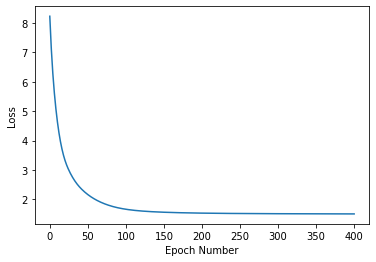

In [6]:
import matplotlib.pyplot as plt
plt.plot([epoch for epoch in range(num_epochs)],losses)
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

### Displaying the embedding vector
* Using pandas dataframe to display the embedding matrix 

In [7]:
import pandas as pd
embedding_matrix=np.array(W1.data)

dfl=pd.DataFrame(embedding_matrix)
dfl.columns=[ind_to_word[i] for i in range(vocab_size)]
dfl.index=['dim'+str(i+1) for i in range(embedding_dim)]
print('Embedding Matrix')
dfl

Embedding Matrix


,queen,india,nairobi,oslo,would,man,king,mango,like,of,norway,she,is,a,orange,the,juice,i,woman,kenya,capital,some,he,apple,delhi
dim1,-0.036161,-0.102818,0.575723,1.819240,0.360302,-1.019552,-0.759313,0.533259,-0.076990,-0.975822,-0.350059,-0.954930,-0.147861,-0.011795,0.048027,-0.861844,0.991304,-1.489596,0.615153,-0.727514,-0.160205,0.213543,0.122754,0.803406,-1.029880
dim2,-1.327287,-1.955472,-0.095996,-0.843279,-0.756120,-0.176712,0.193823,1.105958,-0.877038,0.084158,0.049071,0.499593,2.317803,-0.060683,0.748795,-0.761271,-1.087147,0.401755,-0.358497,-0.159798,0.232910,-0.804367,0.943587,0.847443,0.424028
dim3,1.559137,0.792662,0.437843,-0.744809,-1.124589,0.778172,-1.153513,-0.484632,1.441613,-0.914049,-1.027999,-0.903392,-0.324093,0.138993,1.209657,0.258687,-0.074783,0.231863,-0.245299,-0.383043,-0.539475,0.135586,0.145102,0.983340,0.548632
dim4,1.084259,1.199160,-1.618858,0.001335,1.857647,-0.985901,0.915909,-1.074010,0.430219,0.801788,-0.742924,0.386327,0.638836,-0.785777,0.851662,1.045429,0.806938,-0.043287,-0.533952,0.202971,-0.956553,-1.167984,-0.516710,-0.111578,-0.850401
dim5,0.507743,1.490355,1.059935,1.215951,1.572900,0.257085,-0.615260,-1.005169,1.097573,-0.482634,0.078410,-1.386575,-0.784253,-1.374583,-0.046421,1.286935,0.993532,1.010255,-0.756422,-0.000856,-1.683317,-0.909158,-1.982054,-0.791789,-1.468674
dim6,0.009620,0.467953,1.019413,-1.000317,-0.430615,2.078317,-0.338524,1.235388,1.636325,-1.014420,-0.042448,-0.572622,0.481027,2.318200,-1.618564,2.182865,0.713468,-1.435737,-0.443694,0.984956,0.526437,-0.367494,0.440313,-1.322046,0.849481
dim7,0.465516,0.452202,0.651260,0.910312,0.448697,0.765616,1.885428,0.022406,0.745021,0.736463,0.082485,0.782537,-0.088190,0.186757,-0.336633,1.983537,1.219118,0.298435,0.212607,0.828066,0.011854,0.118877,0.246666,-0.746054,0.810700
dim8,0.054574,-0.499396,-1.200197,-1.185314,0.075599,0.084761,0.103030,-1.123246,0.178857,0.073867,0.576864,-0.708594,-0.700726,-0.978337,1.557905,0.492451,0.277952,-0.313633,2.475273,0.849869,0.423280,-0.587830,1.666239,0.756231,-0.920931
dim9,0.147006,-0.433515,-1.306297,-1.646120,-2.240684,0.483781,-1.271074,-0.951202,-0.417891,0.518677,0.839030,-0.358746,1.614945,-0.734380,-0.062265,-0.486522,-1.202685,0.619786,-0.887143,0.432844,-1.186051,0.182525,-0.685745,-0.368727,-0.619400
dim10,-1.307957,0.119826,1.266431,-0.202127,-0.080148,-0.091558,0.232131,-1.136838,-1.013504,-0.565940,-0.056349,0.317403,-0.250442,1.677602,-0.205736,0.278112,-1.543194,0.301899,-0.552293,1.330651,0.479273,0.565354,-1.129121,-0.454156,-0.582531


### Conclusion:
If you've used the default/pre-defined parameters you might have noticed that the embedding vector isn't quite accurate. This is because, the model is limited in it's ability to generalise over a large corpus of training sentences.

This can be understood by the fact even us humans would find it hard to pick up similar words and analogies given a limited set of sentences from a completely unfamiliar language.

So I hope this notebook along with the Nishant_NLP_Word2Vec.md (Link: https://github.com/Nishant11769/Nishant_Word2Vec/blob/master/Nishant_NLP_Word2Vec.md) file has helped you gain a theoritical and practical understanding on how to implement the Word2Vec model.

Thank You!!